# TxMM project

Fleur Brandsen - s1016202

Dataset used in this project: https://www.kaggle.com/datasets/thespacefreak/taylor-swift-song-lyrics-all-albums

In [1]:
# !pip install --upgrade imutils

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import plotly.express as px
import plotly.graph_objs as go
import collections
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, sent_tokenize
from sklearn.cluster import KMeans

In [2]:
# importing all datasets (1 per album)
rough_data01 = pd.read_csv("data/01-taylor_swift.csv")
rough_data02 = pd.read_csv("data/02-fearless_taylors_version.csv")
rough_data03 = pd.read_csv("data/03-speak_now_deluxe_package.csv")
rough_data04 = pd.read_csv("data/04-red_deluxe_edition.csv")
rough_data05 = pd.read_csv("data/05-1989_deluxe.csv")
rough_data06 = pd.read_csv("data/06-reputation.csv")
rough_data07 = pd.read_csv("data/07-lover.csv")
rough_data08 = pd.read_csv("data/08-folklore_deluxe_version.csv")
rough_data09 = pd.read_csv("data/09-evermore_deluxe_version.csv", encoding="'utf-8'")
rough_datasets = [rough_data01, rough_data02, rough_data03, rough_data04, rough_data05, rough_data06, rough_data07, rough_data08, rough_data09]

In [3]:
# for 1 dataset it prints the tracknames
def print_tracknames(dataset):
    names = pd.unique(dataset[["track_title"]].values.ravel())
    for name in names:
        print(name)

# for the given datasets it prints the title of the album and the names of its tracks
def print_all_tracknames(datasets):
    for dataset in datasets:
        print("\n", dataset["album_name"][0].upper())
        print_tracknames(dataset)            
            
# for a given dataset it concatenates all lyrics that belong to the same song and returns 
# a new dataframe that has 1 row per song
def concatenate_lyrics(rough_data):
    data = rough_data.copy()
    data['lyric'] = rough_data.groupby(['track_n'])['lyric'].transform(lambda x: ". ".join(x))
    data = data.drop(columns="line")
    data = data.drop_duplicates().reset_index(drop = True)
    return data

In [4]:
# concatenating the lyrics per song for all albums (1 datasete per album)
data01 = concatenate_lyrics(rough_data01)
data02 = concatenate_lyrics(rough_data02)
data03 = concatenate_lyrics(rough_data03)
data04 = concatenate_lyrics(rough_data04)
data05 = concatenate_lyrics(rough_data05)
data06 = concatenate_lyrics(rough_data06)
data07 = concatenate_lyrics(rough_data07)
data08 = concatenate_lyrics(rough_data08)
data09 = concatenate_lyrics(rough_data09)
datasets = [data01, data02, data03, data04, data05, data06, data07, data08, data09]

In [5]:
# Functions taken from assignment 3 and adapted to fit this project

# Putting the samples in a dictionary containing the track title as the key and the lyrics as the value
def load_samples(data):
    samples = {}
    for i, track in data.iterrows():
        trackname = track["track_title"]
        samples[trackname] = track["lyric"]
    return samples

# Actually creating the clusters based on the feature vectors
def perform_k_means_clustering(feature_vectors, n_clusters = 6):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42).fit(feature_vectors)
    y_kmeans = kmeans.predict(feature_vectors)
    return y_kmeans

In [6]:
def create_vector(text):
    stop_words = set(stopwords.words('english'))

    bag_of_words = [x for x in wordpunct_tokenize(text)]
    bag_of_sents = [x for x in sent_tokenize(text)]
    bag_of_chars = []
    [bag_of_chars.extend(list(x.lower())) for x in wordpunct_tokenize(text)]

    features = []
    
    # Add the number of words
    features.append(len(bag_of_words))
    
    # Add the number of words, excluding stopwords
    features.append(len([x for x in bag_of_words if x.lower() not in stop_words]))
    
    # Add the average length of words
    avg_length_words = [len(x) for x in bag_of_words]
    features.append(sum(avg_length_words)/len(avg_length_words))
    
    # Add the frequency counts of the most frequent words
    # Add the frequency counts of the least frequent words
    frequent_words = sorted(collections.Counter(bag_of_words).items(), key=lambda x: x[1], reverse=True)
    for i in range(10):
        features.append(frequent_words[i][1])
        features.append(frequent_words[-1-i][1])
        
    # Number of unique words
    features.append(len(frequent_words))

    # Number of long words (length > 9) + ratio compared to total amount of words
    features.append(len([x for x in bag_of_words if len(x)>9]))
    features.append(len([x for x in bag_of_words if len(x)>9]) / len(bag_of_words))

    # Number of short words (length < 3) + ratio compared to total amount of words
    features.append(len([x for x in bag_of_words if len(x)<3]))
    features.append(len([x for x in bag_of_words if len(x)<3]) / len(bag_of_words))

    # Usage of negations. use of "not" and "n't"
    features.append(text.count("not"))
    features.append(text.count("n't"))

    # a vs. an usage
    features.append(text.count("a"))
    features.append(text.count("an"))
    
    # Frequency of pronouns "I", "she", "he" and "they"
    features.append(text.count("I"))
    features.append(text.count("she"))
    features.append(text.count("he"))
    features.append(text.count("they"))

    return features

In [7]:
def clustering(data):
    sample_names = data["track_title"]
    samples = load_samples(data)

    feature_vectors = np.asarray([create_vector(samples[x]) for x in sample_names])
    clusters = perform_k_means_clustering(feature_vectors, n_clusters = 2)
    return clusters

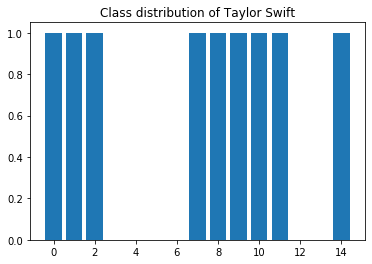

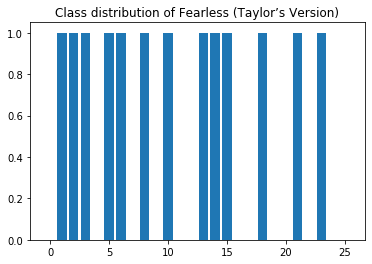

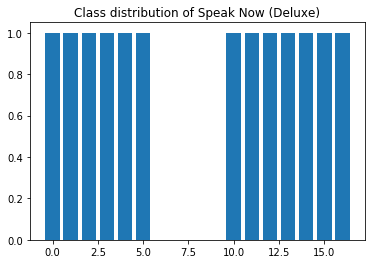

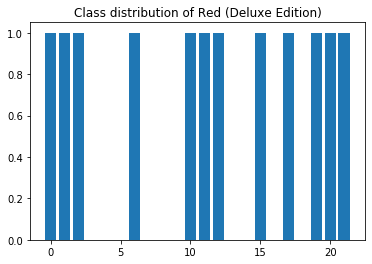

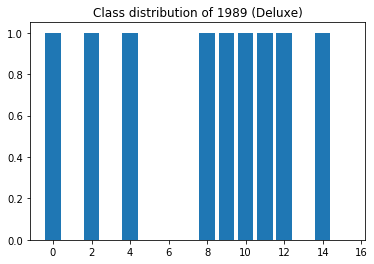

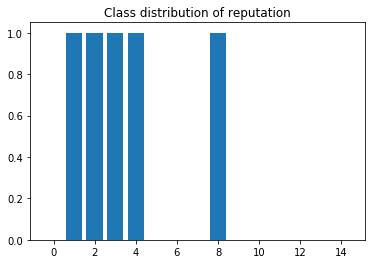

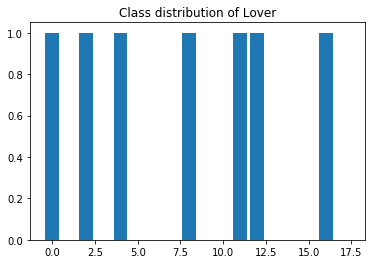

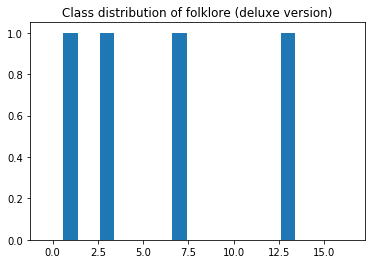

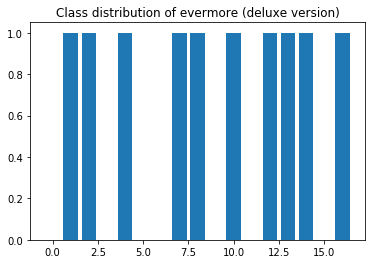

In [8]:
clusters = []
album_names = []
for dataset in datasets:
    album_names.append(dataset.iloc[0]["album_name"])
    result = clustering(dataset)
    clusters.append(result)
    plt.bar(range(len(result)), result)
    plt.title("Class distribution of "+dataset.iloc[0]["album_name"])
    plt.show()

In [9]:
class0 = []
class1 = []
difference = []
for album in clusters:
    class1_count = np.sum(album)
    class1.append(class1_count)
    class0_count = len(album) - class1_count
    class0.append(class0_count)
    difference.append(class1_count - class0_count)

[]

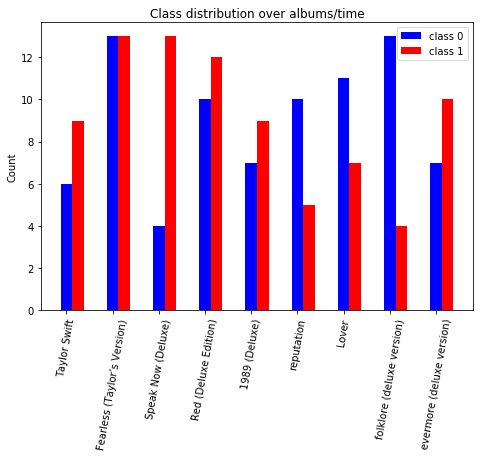

In [10]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
x_vals = np.arange(len(clusters))
ax.bar(x_vals + 0.00, class0, color = 'b', width = 0.25, label = "class 0")
ax.bar(x_vals + 0.25, class1, color = 'r', width = 0.25, label = "class 1")
ax.set_title("Class distribution over albums/time")
plt.xticks(range(len(album_names)), album_names, rotation=80)
ax.set_ylabel("Count")
ax.legend()
plt.plot()

[]

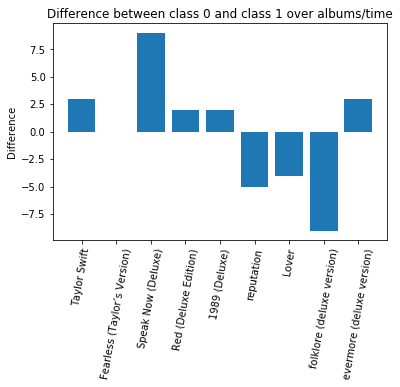

In [13]:
plt.bar(range(len(difference)), difference)
plt.title("Difference between class 0 and class 1 over albums/time")
plt.xticks(range(len(album_names)), album_names, rotation=80)
plt.ylabel("Difference")
plt.plot()